# ResNet for CIFAR-10

In this notebook I implement  [PreResNet](https://arxiv.org/abs/1603.05027) which is a variation of [ResNet](https://arxiv.org/abs/1512.03385), one of the state-of-the-art CNN architecture which locates activation before each convolutional layer (so called pre-activation).

The main blocks implemented herein are:
* plain building block
* residual block
* bottleneck block

In [ ]:
!pip install git+https://github.com/deepvision-class/starter-code

  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-tylgkbqn
  Running command git clone -q https://github.com/deepvision-class/starter-code /tmp/pip-req-build-tylgkbqn
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-cp36-none-any.whl size=10324 sha256=e3fce149bd421b796d1876434cb0d47e7222cf31e495f130be2f0d03338951aa
  Stored in directory: /tmp/pip-ephem-wheel-cache-0_o42bgs/wheels/63/d1/27/a208931527abb98d326d00209f46c80c9d745851d6a1defd10
Successfully built Colab-Utils


In [ ]:
import coutils
from coutils import fix_random_seed

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
NUM_TRAIN = 49000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# CIFAR10 dataset
cifar10_train = dset.CIFAR10('./datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print_every = 100 # Constant to control how frequently we print train loss

print('using device:', device)

using device: cuda:0


In [ ]:
def check_accuracy(loader, model):
  if loader.dataset.train:
    print('Checking accuracy on validation set')
  else:
    print('Checking accuracy on test set')   
  num_correct = 0
  num_samples = 0
  model.eval()  # set model to evaluation mode
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=ltype)
      scores = model(x)
      _, preds = scores.max(1)
      num_correct += (preds == y).sum()
      num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
  return acc

In [ ]:
def adjust_learning_rate(optimizer, lrd, epoch, schedule):
  """
  Multiply lrd to the learning rate if epoch is in schedule
  
  Inputs:
  - optimizer: An Optimizer object we will use to train the model
  - lrd: learning rate decay; a factor multiplied at scheduled epochs
  - epochs: the current epoch number
  - schedule: the list of epochs that requires learning rate update
  
  Returns: Nothing, but learning rate might be updated
  """
  if epoch in schedule:
    for param_group in optimizer.param_groups:
      print('lr decay from {} to {}'.format(param_group['lr'], param_group['lr'] * lrd))
      param_group['lr'] *= lrd

def train(model, optimizer, epochs=1, learning_rate_decay=.1, schedule=[], verbose=True):
  """
  Train a model on CIFAR-10 using the PyTorch Module API.
  
  Inputs:
  - model: A PyTorch Module giving the model to train.
  - optimizer: An Optimizer object we will use to train the model
  - epochs: (Optional) A Python integer giving the number of epochs to train for
  
  Returns: Nothing, but prints model accuracies during training.
  """
  model = model.to(device=device)  # move the model parameters to CPU/GPU
  num_iters = epochs * len(loader_train)
  if verbose:
    num_prints = num_iters // print_every + 1
  else:
    num_prints = epochs
  acc_history = torch.zeros(num_prints, dtype=torch.float)
  iter_history = torch.zeros(num_prints, dtype=torch.long)
  for e in range(epochs):
    
    adjust_learning_rate(optimizer, learning_rate_decay, e, schedule)
    
    for t, (x, y) in enumerate(loader_train):
      model.train()  # put model to training mode
      x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=ltype)

      scores = model(x)
      loss = F.cross_entropy(scores, y)

      # Zero out all of the gradients for the variables which the optimizer
      # will update.
      optimizer.zero_grad()

      # This is the backwards pass: compute the gradient of the loss with
      # respect to each  parameter of the model.
      loss.backward()

      # Actually update the parameters of the model using the gradients
      # computed by the backwards pass.
      optimizer.step()

      tt = t + e * len(loader_train)

      if verbose and (tt % print_every == 0 or (e == epochs-1 and t == len(loader_train)-1)):
        print('Epoch %d, Iteration %d, loss = %.4f' % (e, tt, loss.item()))
        acc = check_accuracy(loader_val, model)
        acc_history[tt // print_every] = acc
        iter_history[tt // print_every] = tt
        print()
      elif not verbose and (t == len(loader_train)-1):
        print('Epoch %d, Iteration %d, loss = %.4f' % (e, tt, loss.item()))
        acc = check_accuracy(loader_val, model)
        acc_history[e] = acc
        iter_history[e] = tt
        print()
  return acc_history, iter_history

## Plain block

PreResNet has a different order of layers from the previously implemented ones; The name of PreResNet comes form this pre-activation architecture.

BatchNorm and ReLU precedes Conv.

For downsampling, we don't introduce MaxPool layers explicitly, but use stride 2 in the first Conv layer in the block.

Concretely, a plain block accepts a feature map of shape $C_{in} \times H_{in} \times W_{in}$ and produces a feature map of shape $C_{out} \times H_{out} \times W_{out}$. If the block performs downsampling, then $W_{out}=W_{in}/2$ and $H_{out}=H_{in}/2$; otherwise $H_{out}=H_{in}$ and $W_{out}=W_{in}$. The plain block consists of the following six layers in order:

1. Spatial Batch normalization
2. ReLU
3. Convolutional layer with `Cout` 3x3 filters, zero-padding of 1, and stride 2 if downsampling; otherwise stride 1
4. Spatial Batch normalization
5. ReLU
6. Convolutional layer with `Cout` 3x3 filters, with zero-padding of 1


In [ ]:
class PlainBlock(nn.Module):
  def __init__(self, Cin, Cout, downsample=False):
    super().__init__()
    self.stride = (2, 2) if downsample else (1, 1)
    self.net = nn.Sequential(
                   nn.BatchNorm2d(Cin),
                   nn.ReLU(inplace=True),
                   nn.Conv2d(Cin, Cout, kernel_size=(3, 3), stride=self.stride, padding=1),
                   nn.BatchNorm2d(Cout),
                   nn.ReLU(inplace=True),
                   nn.Conv2d(Cout, Cout, kernel_size=(3, 3), stride=1, padding=1)
    )

  def forward(self, x):
    return self.net(x)

In [ ]:
data = torch.zeros(2, 3, 5, 6)
model = PlainBlock(3, 10)
if list(model(data).shape) == [2, 10, 5, 6]:
  print('The output of PlainBlock without downsampling has a *correct* dimension!')
else:
  print('The output of PlainBlock without downsampling has an *incorrect* dimension! expected:', [2, 10, 5, 6], 'got:', list(model(data).shape))

data = torch.zeros(2, 3, 5, 6)
model = PlainBlock(3, 10, downsample=True)
if list(model(data).shape) == [2, 10, 3, 3]:
  print('The output of PlainBlock with downsampling has a *correct* dimension!')
else:
  print('The output of PlainBlock with downsampling has an *incorrect* dimension! expected:', [2, 10, 3, 3], 'got:', list(model(data).shape))

The output of PlainBlock without downsampling has a *correct* dimension!
The output of PlainBlock with downsampling has a *correct* dimension!


## Residual block

A residual block adds a residual connection to a plain block. Let $\mathcal{F}$ be a plain block; then the residual version  $\mathcal{R}$ of the plain block $\mathcal{F}$ computes:

$\mathcal{R}(x) = \mathcal{F}(x) + x$

However, this implementation will only work if the output from the plain block $\mathcal{F}(x)$ has the same shape as the input $x$. There are two cases where the output of the plain block can have a different shape than the input:

1. The number of output channels $C_{out}$ is different from the number of input channels $C_{in}$
2. The plain block $\mathcal{F}$ performs spatial downsampling

To deal with these cases, we need generalize our definition of the residual block and add a *shortcut connection* $\mathcal{G}$:

$\mathcal{R}(x) = \mathcal{F}(x) + \mathcal{G}(x)$

There are three cases for the shortcut connection $\mathcal{G}$:

1. If $C_{in}=C_{out}$ and $\mathcal{F}$ does not perform downsampling, then $\mathcal{F}(x)$ will have the same shape as $x$, so $\mathcal{G}$ is the identity function: $\mathcal{G}(x) = x$
2. If $C_{in} \neq C_{out}$ and $\mathcal{F}$ does not downsample, then $\mathcal{G}$ is a 1x1 convolution with $C_{out}$ filters and stride 1.
3. If $\mathcal{F}$ downsamples, then $\mathcal{G}$ is a 1x1 convolution with $C_{out}$ filters and stride 2.


In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, Cin, Cout, downsample=False):
    super().__init__()

    self.shortcut = None # G
    if (Cin == Cout) and not downsample:
      self.shortcut = nn.Identity()
    elif (Cin != Cout) and not downsample:
      self.shortcut = nn.Conv2d(Cin, Cout, (1, 1), 1)
    elif downsample:
      self.shortcut = nn.Conv2d(Cin, Cout, (1, 1), 2)
    self.block = PlainBlock(Cin, Cout, downsample=downsample)
  
  def forward(self, x):
    return self.block(x) + self.shortcut(x)

In [ ]:
data = torch.zeros(2, 3, 5, 6)
model = ResidualBlock(3, 10)
if list(model(data).shape) == [2, 10, 5, 6]:
  print('The output of ResidualBlock without downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock without downsampling has an *incorrect* dimension! expected:', [2, 10, 5, 6], 'got:', list(model(data).shape))

data = torch.zeros(2, 3, 5, 6)
model = ResidualBlock(3, 10, downsample=True)
if list(model(data).shape) == [2, 10, 3, 3]:
  print('The output of ResidualBlock with downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock with downsampling has an *incorrect* dimension! expected:', [2, 10, 3, 3], 'got:', list(model(data).shape))

The output of ResidualBlock without downsampling has a *correct* dimension!
The output of ResidualBlock with downsampling has a *correct* dimension!


## Residual stage

In [ ]:
class ResNetStage(nn.Module):
  def __init__(self, Cin, Cout, num_blocks, downsample=True,
               block=ResidualBlock):
    super().__init__()
    blocks = [block(Cin, Cout, downsample)]
    for _ in range(num_blocks - 1):
      blocks.append(block(Cout, Cout))
    self.net = nn.Sequential(*blocks)
  
  def forward(self, x):
    return self.net(x)

In [ ]:
print('Plain block stage:')
print(ResNetStage(3, 4, 2, block=PlainBlock))
print('Residual block stage:')
print(ResNetStage(3, 4, 2, block=ResidualBlock))

Plain block stage:
ResNetStage(
  (net): Sequential(
    (0): PlainBlock(
      (net): Sequential(
        (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(3, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
        (5): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): PlainBlock(
      (net): Sequential(
        (0): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
        (5): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
)
Residual block st

## Residual stem

A "stem" layer is required at the beginning of the network, which increases the number of channels while keeping the other dimensions.

In [ ]:
class ResNetStem(nn.Module):
  def __init__(self, Cin=3, Cout=8):
    super().__init__()
    layers = [
        nn.Conv2d(Cin, Cout, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
    ]
    self.net = nn.Sequential(*layers)
    
  def forward(self, x):
    return self.net(x)

In [ ]:
data = torch.zeros(2, 3, 5, 6)
model = ResNetStem(3, 10)
if list(model(data).shape) == [2, 10, 5, 6]:
  print('The output of ResidualBlock without downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock without downsampling has an *incorrect* dimension! expected:', [2, 10, 5, 6], 'got:', list(model(data).shape))

The output of ResidualBlock without downsampling has a *correct* dimension!


## ResNet class

For general applicability, the class will get a dictionary of the architecture specification as an input, and parse it to build a CNN.

Here we provide a couple of examples of specification;
`networks` is a collection of pre-defined network specifications, where each can be called by `get_resnet(key)`, where key is the name of the network, e.g., `get_resnet('resnet32')` will return a ResNet with 32 layers.

Each specification consists of multiple tuples which correspond to a macro block (`ResNetStage`), and the values in each tuple implies `(num_in_channels, num_out_channels, num_blocks, do_downsample)`.

To avoid dependency on the size of the input, ResNet has an average pooling at the end of the convolutional part, such that the size of the input tensor to the linear layer is always `(batch_size, stage_args[-1][1])`.

In [ ]:
# example of specifications
networks = {
  'plain32': {
    'block': PlainBlock,
    'stage_args': [
      (8, 8, 5, False),
      (8, 16, 5, True),
      (16, 32, 5, True),
    ]
  },
  'resnet32': {
    'block': ResidualBlock,
    'stage_args': [
      (8, 8, 5, False),
      (8, 16, 5, True),
      (16, 32, 5, True),
    ]
  },
}

In [ ]:
class ResNet(nn.Module):
  def __init__(self, stage_args, Cin=3, block=ResidualBlock, num_classes=10):
    super().__init__()

    self.stem = ResNetStem(Cin, stage_args[0][0])
    
    self.layers = [ResNetStage(*x) for x in stage_args]
    self.cnn = nn.Sequential(*self.layers)
    self.pooling = nn.AvgPool2d(7)
    self.fc = nn.Linear(stage_args[-1][1], num_classes)
  
  def forward(self, x):
    x = self.stem(x)
    x = self.cnn(x)
    pooled_x = self.pooling(x)
    pooled_x = pooled_x.view(pooled_x.size(0), -1)
    scores = self.fc(pooled_x)
    return scores

def get_resnet(name):
  return ResNet(**networks[name])

## Train model!


In [ ]:
# def init_module(model):
#   for m in model.modules():
#     if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
#       nn.init.kaiming_normal_(m.weight.data)
#       if m.bias is not None: nn.init.zeros_(m.bias.data)
#     elif isinstance(m, nn.BatchNorm2d):
#       nn.init.ones_(m.weight.data)
#       if m.bias is not None: nn.init.zeros_(m.bias.data)

names = ['plain32', 'resnet32']
acc_history_dict = {}
iter_history_dict = {}
for name in names:
  fix_random_seed(0)
  print(name, '\n')
  model = get_resnet(name)
#   init_module(model)
  
  optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=.9, weight_decay=1e-4)

  acc_history, iter_history = train(model, optimizer, epochs=10, schedule=[6, 8], verbose=False)
  acc_history_dict[name] = acc_history
  iter_history_dict[name] = iter_history

plain32 

Epoch 0, Iteration 765, loss = 1.1947
Checking accuracy on validation set
Got 564 / 1000 correct (56.40)

Epoch 1, Iteration 1531, loss = 1.1899
Checking accuracy on validation set
Got 577 / 1000 correct (57.70)

Epoch 2, Iteration 2297, loss = 0.8034
Checking accuracy on validation set
Got 641 / 1000 correct (64.10)

Epoch 3, Iteration 3063, loss = 0.5113
Checking accuracy on validation set
Got 742 / 1000 correct (74.20)

Epoch 4, Iteration 3829, loss = 0.6023
Checking accuracy on validation set
Got 749 / 1000 correct (74.90)

Epoch 5, Iteration 4595, loss = 0.6504
Checking accuracy on validation set
Got 734 / 1000 correct (73.40)

lr decay from 0.01 to 0.001
Epoch 6, Iteration 5361, loss = 0.4900
Checking accuracy on validation set
Got 801 / 1000 correct (80.10)

Epoch 7, Iteration 6127, loss = 0.5157
Checking accuracy on validation set
Got 809 / 1000 correct (80.90)

lr decay from 0.001 to 0.0001
Epoch 8, Iteration 6893, loss = 0.4327
Checking accuracy on validation set
Go

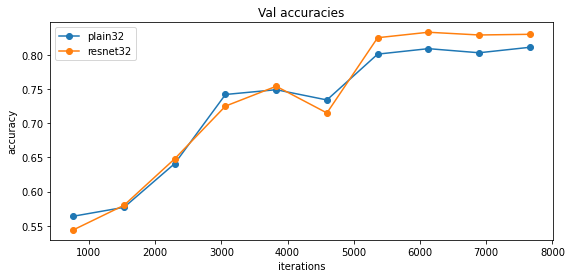

In [ ]:
plt.title('Val accuracies')
for name in names:
  plt.plot(iter_history_dict[name], acc_history_dict[name], '-o')
plt.legend(names, loc='upper left')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.gcf().set_size_inches(9, 4)
plt.show()

## Residual bottleneck block

A bottleneck block is often useful for better efficiency, especially when importing a model to mobile devices.
The residual bottleneck block is similar to the standard residual block, but the plain block part has a different architecture:
it consists of 3 convolutional layers, and the first two convolutional layers have a smaller number of channels.

Here is the specification of the bottleneck block:

1. Spatial Batch normalization
2. ReLU
3. Convolutional layer with `Cout // 4` 1x1 filters, stride 2 if downsampling; otherwise stride 1
4. Spatial Batch normalization
5. ReLU
6. Convolutional layer with `Cout // 4` 3x3 filters, with zero-padding of 1
7. Spatial Batch normalization
8. ReLU
9. Convolutional layer with `Cout` 1x1 filters

In [ ]:
class ResidualBottleneckBlock(nn.Module):
  def __init__(self, Cin, Cout, downsample=False):
    super().__init__()
    self.stride = (2, 2) if downsample else (1, 1)
    self.block = nn.Sequential(
                   nn.BatchNorm2d(Cin),
                   nn.ReLU(inplace=True),
                   nn.Conv2d(Cin, Cout//4, kernel_size=(3, 3), stride=self.stride, padding=1),
                   nn.BatchNorm2d(Cout//4),
                   nn.ReLU(inplace=True),
                   nn.Conv2d(Cout//4, Cout//4, kernel_size=(3, 3), padding=1),
                   nn.BatchNorm2d(Cout//4),
                   nn.ReLU(inplace=True),
                   nn.Conv2d(Cout//4, Cout, kernel_size=(1, 1)),
    )
    if (Cin == Cout) and not downsample:
      self.shortcut = nn.Identity()
    elif (Cin != Cout) and not downsample:
      self.shortcut = nn.Conv2d(Cin, Cout, (1, 1), 1)
    elif downsample:
      self.shortcut = nn.Conv2d(Cin, Cout, (1, 1), 2)
    
  def forward(self, x):
    print(self.block(x).shape, self.shortcut(x).shape)
    return self.block(x) + self.shortcut(x)

In [ ]:
data = torch.zeros(2, 3, 5, 6)
model = ResidualBottleneckBlock(3, 10)
if list(model(data).shape) == [2, 10, 5, 6]:
  print('The output of ResidualBlock without downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock without downsampling has an *incorrect* dimension! expected:', [2, 10, 5, 6], 'got:', list(model(data).shape))

data = torch.zeros(2, 3, 5, 6)
model = ResidualBottleneckBlock(3, 10, downsample=True)
if list(model(data).shape) == [2, 10, 3, 3]:
  print('The output of ResidualBlock with downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock with downsampling has an *incorrect* dimension! expected:', [2, 10, 3, 3], 'got:', list(model(data).shape))

torch.Size([2, 10, 5, 6]) torch.Size([2, 10, 5, 6])
The output of ResidualBlock without downsampling has a *correct* dimension!
torch.Size([2, 10, 3, 3]) torch.Size([2, 10, 3, 3])
The output of ResidualBlock with downsampling has a *correct* dimension!


In [ ]:
# example of specification
networks.update({
  'resnet47': {
    'block': ResidualBottleneckBlock,
    'stage_args': [
      (32, 32, 5, False),
      (32, 64, 5, True),
      (64, 128, 5, True),
    ],
  },
})

print(get_resnet('resnet47'))

ResNet(
  (stem): ResNetStem(
    (net): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
  )
  (cnn): Sequential(
    (0): ResNetStage(
      (net): Sequential(
        (0): ResidualBlock(
          (shortcut): Identity()
          (block): PlainBlock(
            (net): Sequential(
              (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (1): ReLU(inplace=True)
              (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (4): ReLU(inplace=True)
              (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
          )
        )
        (1): ResidualBlock(
          (shortcut): Identity()
          (block): PlainBlock(
            (net): Sequential(
              (0): BatchNorm2d(32, eps=1e-05, mom